In [15]:
import torch
import torch.nn as nn
from torch.nn import functional as F
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [3]:
with open ('davidc.txt','r',encoding='utf8') as f:
    text = f.read()
print(len(text))
print(text[:200])

1954026
﻿The Project Gutenberg eBook of David Copperfield
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
wh


In [4]:
#character-level analysis
chars = sorted(set(text))
print(chars)

['\n', ' ', '!', '#', '$', '%', '&', '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '—', '‘', '’', '“', '”', '•', '™', '\ufeff']


In [5]:
print(len(chars))
vocab_size = len(chars)
#encode the character strings of the vocabulary to integers
string_to_int = {ch:i for i,ch in enumerate(chars)}
int_to_string = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])


'''this process is called character-level tokenizing. It encodes each character of the vocabulary into an integer value.'''

# print(encode('hello'))
# encoded_hello = encode('hello')
# decoded_hello = decode(encoded_hello)
# print(decoded_hello)

90


'this process is called character-level tokenizing. It encodes each character of the vocabulary into an integer value.'

In [6]:
#convert the entire encoded data into a tensor (multi-dimensional array)
data = torch.tensor(encode(text), dtype = torch.long)
print(data[:100])

tensor([89, 46, 63, 60,  1, 42, 73, 70, 65, 60, 58, 75,  1, 33, 76, 75, 60, 69,
        57, 60, 73, 62,  1, 60, 28, 70, 70, 66,  1, 70, 61,  1, 30, 56, 77, 64,
        59,  1, 29, 70, 71, 71, 60, 73, 61, 64, 60, 67, 59,  0,  1,  1,  1,  1,
         0, 46, 63, 64, 74,  1, 60, 57, 70, 70, 66,  1, 64, 74,  1, 61, 70, 73,
         1, 75, 63, 60,  1, 76, 74, 60,  1, 70, 61,  1, 56, 69, 80, 70, 69, 60,
         1, 56, 69, 80, 78, 63, 60, 73, 60,  1])


In [13]:
#implement the bi-gram model - predicts the next token based on the preceeding token
n = int(0.8*len(data))

#2 hyperparameters
block_size=8
batch_size = 4
#split 80-20 training and validation data
'''
Training on 80% of the data allows for generating newer texts of the same corpus instead of the exact text.
This is because it doesn't see 20% of the data, so it allows for more generalization.
'''
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split=="train" else val_data
    ix = torch.randint(len(data)-block_size, (batch_size,))
    print(ix)
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+1+block_size] for i in ix])
    x,y = x.to(device),y.to(device)
    return x,y

x,y = get_batch("train")
print('inputs: ')
print(x.shape)
print(x)
print('targets: ')
print(y.shape)
print(y)


tensor([ 671445, 1116984, 1267634,  136806])
inputs: 
torch.Size([4, 8])
tensor([[ 1, 56, 69, 59,  0, 67, 70, 70],
        [67, 76, 69, 62, 60, 12,  1, 30],
        [68, 60, 26, 84,  1, 74, 56, 64],
        [62, 62, 70, 75, 75, 80, 26, 84]], device='mps:0')
targets: 
torch.Size([4, 8])
tensor([[56, 69, 59,  0, 67, 70, 70, 66],
        [76, 69, 62, 60, 12,  1, 30, 73],
        [60, 26, 84,  1, 74, 56, 64, 59],
        [62, 70, 75, 75, 80, 26, 84,  0]], device='mps:0')


In [9]:
#input - current word
x = train_data[:block_size]
#output - next word given the current word
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print('when input is ', context, ' the output is ', target)

when input is  tensor([89])  the output is  tensor(46)
when input is  tensor([89, 46])  the output is  tensor(63)
when input is  tensor([89, 46, 63])  the output is  tensor(60)
when input is  tensor([89, 46, 63, 60])  the output is  tensor(1)
when input is  tensor([89, 46, 63, 60,  1])  the output is  tensor(42)
when input is  tensor([89, 46, 63, 60,  1, 42])  the output is  tensor(73)
when input is  tensor([89, 46, 63, 60,  1, 42, 73])  the output is  tensor(70)
when input is  tensor([89, 46, 63, 60,  1, 42, 73, 70])  the output is  tensor(65)


In [10]:
'''
if we stack up such blocks together to parallely perform such sequential processing per block, it's called batch_size. This is the hyperparameter used to accelerate the training process and make it more efficient.
These stacked up blocks, batches, can be sent to the GPU to accelerate the process.
This is a good way to scale language models
'''

"\nif we stack up such blocks together to parallely perform such sequential processing per block, it's called batch_size. This is the hyperparameter used to accelerate the training process and make it more efficient.\nThese stacked up blocks, batches, can be sent to the GPU to accelerate the process.\nThis is a good way to scale language models\n"

In [4]:
'''
How do we calculate the loss function?

Consider the number of correct predictions/ total number of predictions.
Let's say we have a vocab size of 80. Without any training, there is a 1 in 80 chance we predict the next token correctly.
Take the negative log likelihood of this, that becomes your loss.

-ln(1/80) -> this value is around 4.
Generally, likelihood is the probability of the entire dataset, we compute the probabilities of the correctly predicted label given an input.
In machine learning, we call these softmax probabilities. It converts logit values into probabilities.
So if the labels' softmax probabilities are cat-0.7, dog-0.2, mouse-0.1, then the likelihood is the probability that the model assigns to the correct label.
If each sample in the dataset is independent, then the likelihood of the entire dataset is the product of all probabilities.
Why do we take log?
Multiplying these probabilities between 0-1 will lead to a very small number, so we take the logarithm of it. Negative log makes it a minimization problem, since we want to minimize the loss.
'''

"\nHow do we calculate the loss function?\n\nConsider the number of correct predictions/ total number of predictions.\nLet's say we have a vocab size of 80. Without any training, there is a 1 in 80 chance we predict the next token correctly.\nTake the negative log likelihood of this, that becomes your loss.\n\n-ln(1/80) -> this value is around 4.\nGenerally, likelihood is the probability of the entire dataset, we compute the probabilities of the correctly predicted label given an input.\nIn machine learning, we call these softmax probabilities. It converts logit values into probabilities.\nSo if the labels' softmax probabilities are cat-0.7, dog-0.2, mouse-0.1, then the likelihood is the probability that the model assigns to the correct label.\nIf each sample in the dataset is independent, then the likelihood of the entire dataset is the product of all probabilities.\nWhy do we take log?\n\n\n"

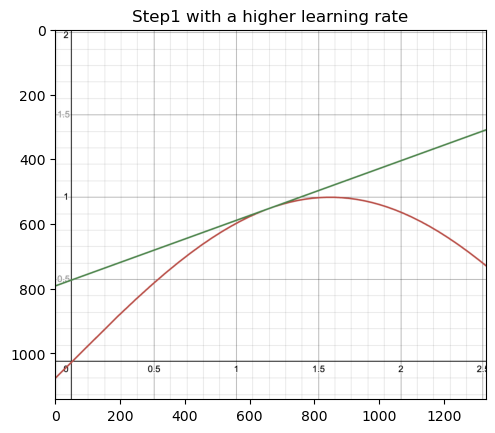

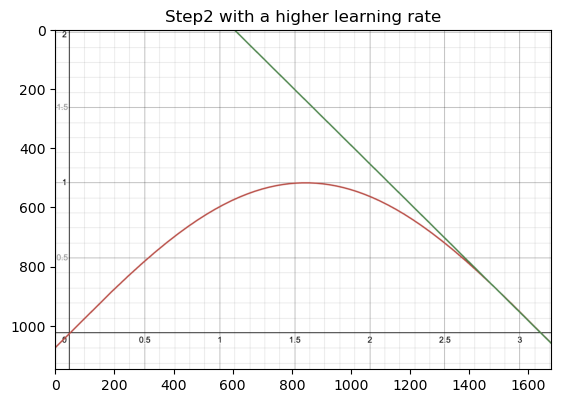

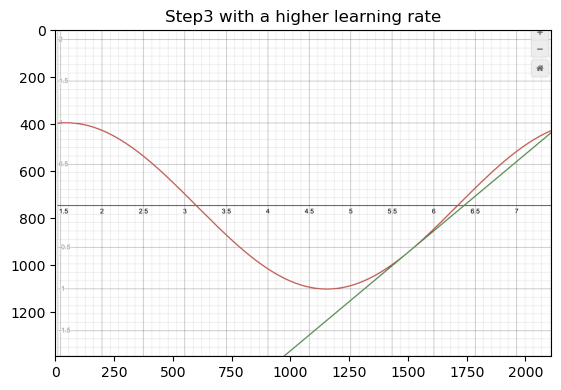

"\nNotice how quickly we're descending and ascending, this is because of a higher learning rate. We're taking bigger steps while trying to descend to a minimal value.\nAn optimizer adjusts these parameters by experimenting in different ways.\nIf we set a low learning rate, the step-size is smaller, and we can reach the local best minima without missing it.\n"

In [10]:
'''
Generally we follow 'gradient descent' to minimize the loss function.

A refresher on derivates: how much does f(x) change with respect to a change in x.
Graphically, the derivate at a point is the slope of the tangent at that point to the curve.
If slope is positive, function is increasing. Negative, function decreases. If it's zero, it's flat. We're at max or min.

In gradient descent, we choose the parameters based on how the loss is changing. So, follow the negative slope until you reach a point with minimal loss.
Gradient descent is an optimizer - to choose the best parameters to minimize the loss function.

What does an optimizer do?

An optimizer tweaks the parameters to minimize the loss function.

'''
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image1 = mpimg.imread("STEP-1.png")
plt.title("Step1 with a higher learning rate")
plt.imshow(image1)
plt.show()

image2 = mpimg.imread("STEP-2.png")
plt.title("Step2 with a higher learning rate")
plt.imshow(image2)
plt.show()

image3 = mpimg.imread("STEP-3.png")
plt.title("Step3 with a higher learning rate")
plt.imshow(image3)
plt.show()

'''
Notice how quickly we're descending and ascending, this is because of a higher learning rate. We're taking bigger steps while trying to descend to a minimal value.
An optimizer adjusts these parameters by experimenting in different ways.
If we set a low learning rate, the step-size is smaller, and we can reach the local best minima without missing it.
'''


In [12]:
"""
Some popular optimizers available in Pytorch

1. Adam - adaptive first and second moments
keep an exponential moving average of gradients (momentum) and of squared gradients (adaptive step-size), along with bias correction.

What do these terms mean?
"EXPONENTIAL MOVING AVERAGE OF GRADIENTS"
This is "momentum" - moving in a stable direction. Safe to increase the speed of learning because there are no bumps.

new_direction = 0.9*old_direction + 0.1*today's push
(0.9 - memory - closer to 1 means longer memory, 0 - no memory)


"SQUARED GRADIENTS"

Determines safe speed ( stable step size ) - how big is each coordinate's step.

Adam - great default optimizer, fast to train.

2. AdamW - Adam with weight decay
Weight decay - penalizes large weights, nudging them toward 0.
applies regularization on weights, instead of adding to the gradient.
This improves generalization, best fit for deep nets and transformers.

3. SparseAdam - only updates parameters whose gradients are non-zero
Generally used for embeddings - which require minimal updates.

4. SGD (Stochastic Gradient Descent)
Kind of batch-wise updates. Instead of exploring the gradients over the entire dataset, perform it on a mini-batch. So it's kind of noisy, but less expensive to afford.
It's more useful for generalization.

"""

'\nSome popular optimizers available in Pytorch\n\n1. Adam - adaptive first and second moments\nkeep an exponential moving average of gradients (momentum) and of squared gradients (adaptive step-size), along with bias correction.\n\nWhat do these terms mean?\n"EXPONENTIAL MOVING AVERAGE OF GRADIENTS"\nThis is "momentum" - moving in a stable direction. Safe to increase the speed of learning because there are no bumps.\n\nnew_direction = 0.9*old_direction + 0.1*today\'s push\n(0.9 - memory - closer to 1 means longer memory, 0 - no memory)\n\n\n"SQUARED GRADIENTS"\n\nDetermines safe speed ( stable step size ) - how big is each coordinate\'s step.\n\nAdam - great default optimizer, fast to train.\n\n2. AdamW - Adam with weight decay\nWeight decay - penalizes large weights, nudging them toward 0.\napplies regularization on weights, instead of adding to the gradient.\nThis improves generalization, best fit for deep nets and transformers.\n\n3. SparseAdam - only updates parameters whose gradi

In [ ]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        #creating an embedding table
        self.token_embeddings = nn.Embedding(vocab_size, vocab_size)

    #instead of using the default forward pass, it's better to customize it as per the use case.
    #also understand the process, behind the scenes, better for debugging and a lot more flexible.